In [186]:
# Weight CMIP6 model projections based on historical data.
# Uses global mean tas, data processed by Andy Wiltshire
# Uses the weighting scheme of Sanderson et al (2017)
# https://www.geosci-model-dev.net/10/2379/2017/

# dougmcneall@gmail.com

# Load packages
library(ncdf4)
library(fields)

# r = realization index
# i = initialization index
# p = physics index
#f = forcing index

#Bespoke functions

extractModelnames = function(filenames, startstring, stopstring){
  # Function to extract model names from a vector of cmip filenames
  # that have similar startstring and stopstring

  fs = lapply(filenames,regexpr, pattern = startstring)
  fe = lapply(filenames,regexpr, pattern = stopstring)
  out = rep(NA, length(filenames))

  for(i in 1:length(filenames)){
    out[i] = substr(filenames[i], attr(fs[i][[1]], 'match.length')+1, fe[[i]][1]-1)
  }
  out
}

In [187]:
# -----------------------------------------------------------------------------------------------
# Use historical tas compared with hardcrut observations to weight the models.
# Projections are using SSP585 (for maximum signal).
# -----------------------------------------------------------------------------------------------

# data directories
fn.ssp585 = dir('/data/users/hadaw/cmip6/areaavg/tas/', pattern = 'ssp585_r1i1p1')
fn.historical = dir('/data/users/hadaw/cmip6/areaavg/tas/', pattern = 'historical_r1i1p1')

# model name lists
mods.ssp585 = extractModelnames(fn.ssp585, startstring = 'tas_Amon_', stopstring = "_ssp585")
mods.historical = extractModelnames(fn.historical, startstring = 'tas_Amon_',
  stopstring = "_historical")

# Find models common to historical and future projection
common.mods = intersect(mods.ssp585, mods.historical)

nmods = length(common.mods)

fn.ssp585.kept = fn.ssp585[match(common.mods, mods.ssp585)]
fn.historical.kept = fn.historical[ match(common.mods, mods.historical)]

# useful
# https://stackoverflow.com/questions/17215789/extract-a-substring-in-r-according-to-a-pattern
# start with strsplit, pmatch, charmatch

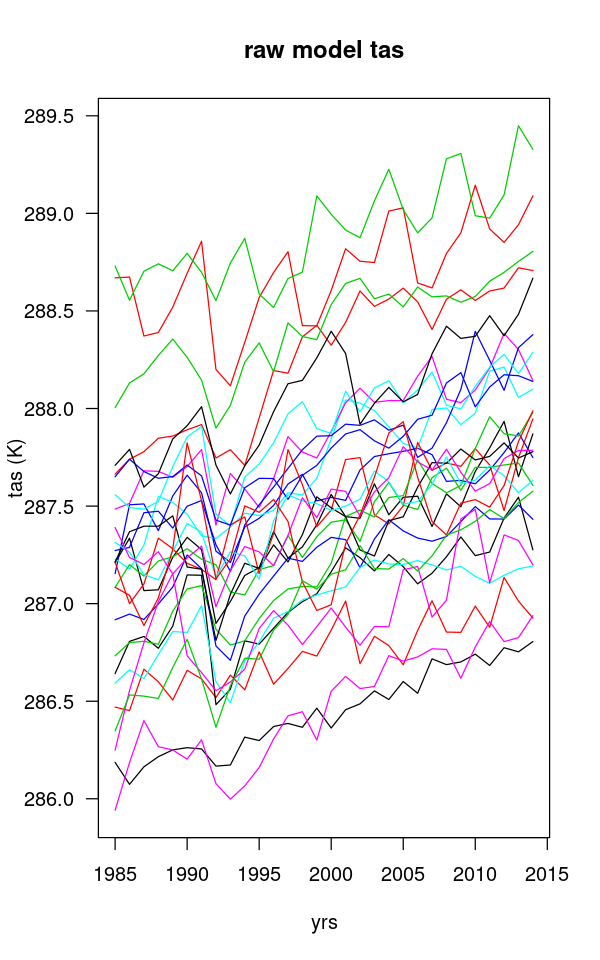

In [188]:
# ---------------------------------------------------------------------------------------
# Load and process historical model data
# ---------------------------------------------------------------------------------------

# Historical years
yrs = 1985:2014
nyr = length(yrs)

#variable matrix (turn this into a function?
varmat = matrix(nrow = length(fn.historical.kept), ncol = nyr)

for(i in 1:length(fn.historical.kept)){
# Open and extract data from the netcdf file
  fn = fn.historical.kept[i]
  fnpath = paste0("/data/users/hadaw/cmip6/areaavg/tas/", fn)

  nc = nc_open(fnpath)

  v = ncvar_get(nc, 'tas')
  nc_close(nc)
  
  vtail = tail(v, nyr)
  varmat[i, ] = vtail
}

par(las = 1)
matplot(yrs, t(varmat), 
        type = 'l', lty = 'solid', main = 'raw model tas', ylab = 'tas (K)')

# Amomalize model runs to the mean of each run
varmat.means = apply(varmat, 1, mean)

# varmat.anom is the variable timeseries matrix anomaly
varmat.anom = sweep(varmat, 1, STATS = varmat.means)

[1] "CAMS-CSM1-0"

[1] 0.100783

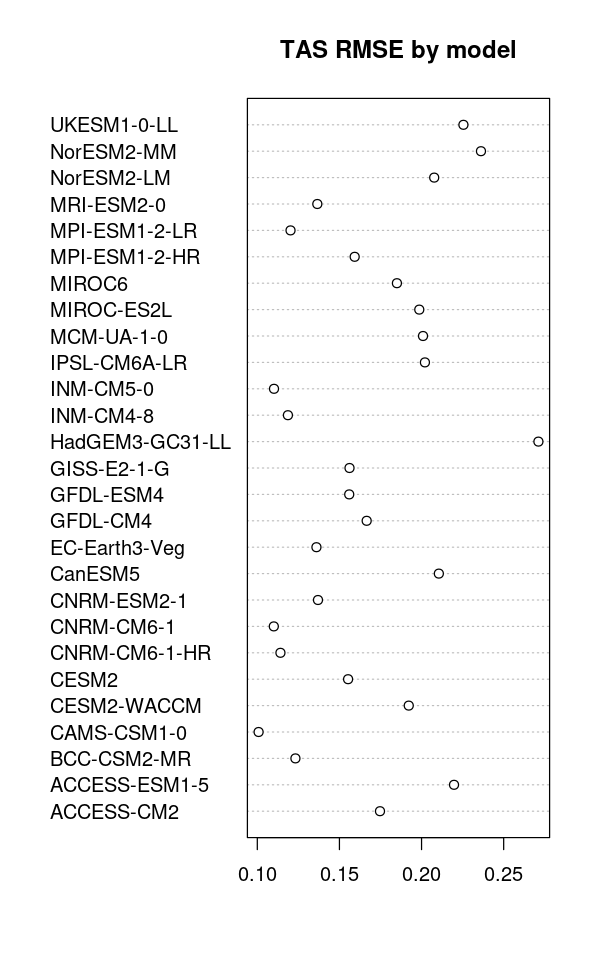

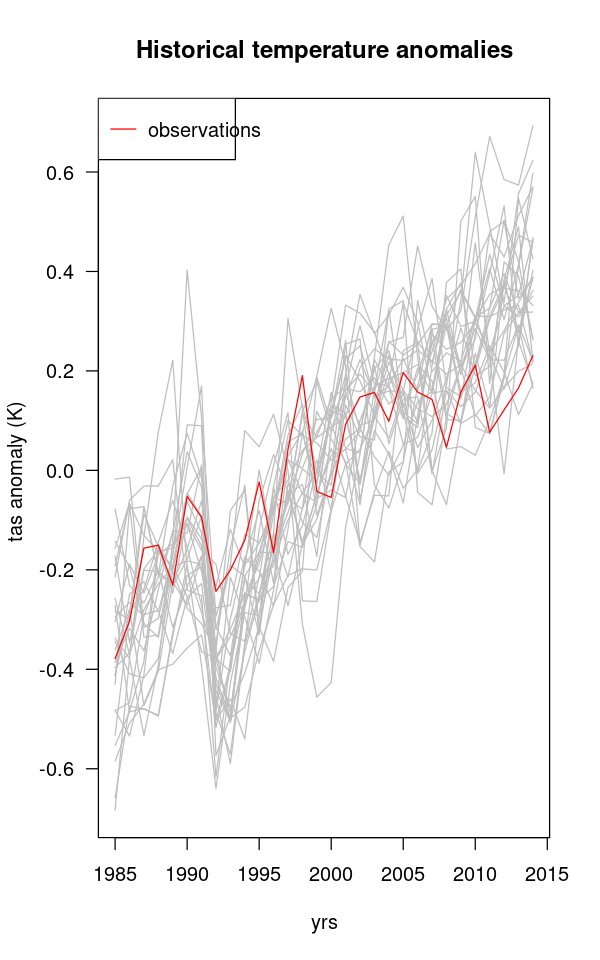

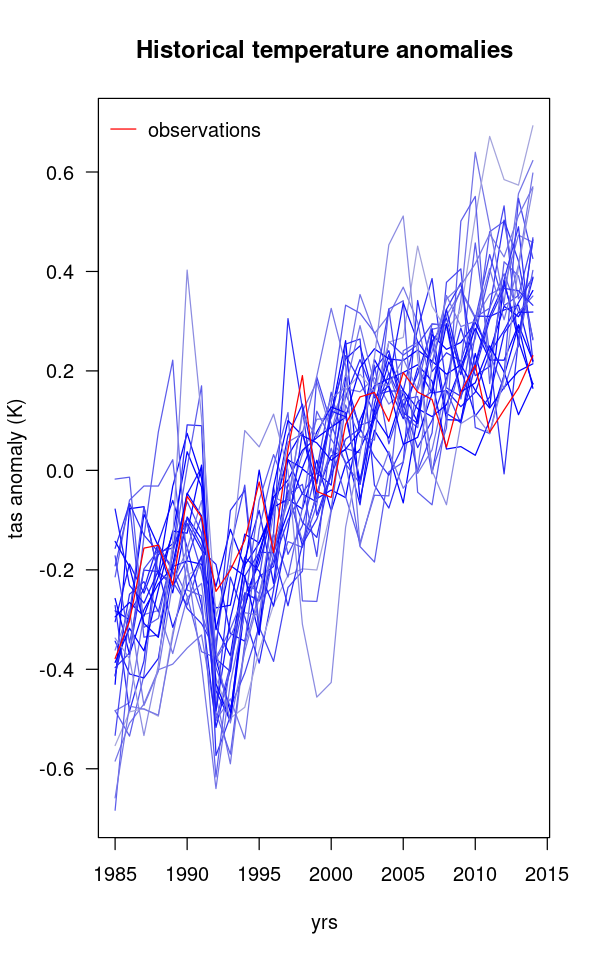

In [189]:
# --------------------------------------------------------------------------------------------
# Load Observations
# --------------------------------------------------------------------------------------------

# Load up the HadCRUT4 data
obsmat = read.table(file = 'https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg.txt')

obsyears = obsmat[,1]
obsmed   = obsmat[,2]

obs.ix = which(obsyears %in% yrs)

obs = obsmed[obs.ix]
obs.anom = obs - mean(obs)


# Matrix of tas errors (differences between the anomalies of the obs and models)
tas.err = sweep(varmat.anom, 2, obs.anom)

# RMSE for tas, the main measure for both skill and similarity
tas.rmse = sqrt(apply( (tas.err)^2, 1, mean))

best.ix = which.min(tas.rmse) # 
common.mods[best.ix]
min.rmse = min(tas.rmse)
min.rmse

# Distance from observations for each of the models.
dotchart(tas.rmse, labels = common.mods, main = 'TAS RMSE by model')

# Plot the timeseries and model historical runs.
par(las = 1)
matplot(yrs, t(varmat.anom), type = 'l', lty = 'solid', col = 'grey',
       main = "Historical temperature anomalies",
       ylab = 'tas anomaly (K) ')
lines(yrs, obs.anom, col = 'red', lty = 'solid')
# lines(yrs, varmat.anom[25,] ,col = 'blue', lty = 'solid') # pick out NOR
legend('topleft', lty = 'solid', col = 'red', legend = 'observations')

#dat$Col <- rbPal(10)[as.numeric(cut(dat$y,breaks = 10))]

rbPal <- colorRampPalette(c('blue', 'lightgrey'))
linecols = rbPal(10)[as.numeric(cut(tas.rmse,breaks = 8))]

par(las = 1)
matplot(yrs, t(varmat.anom), type = 'l', 
        lty = 'solid',
       main = "Historical temperature anomalies",
       ylab = 'tas anomaly (K)', col = linecols
)
lines(yrs, obs.anom, col = 'red', lty = 'solid')
legend('topleft', lty = 'solid', col = 'red', legend = 'observations', bty = 'n')



In [190]:
# -------------------------------------------------------------------
# Weighting section from Sanderson et al. (2017)
# -------------------------------------------------------------------

[1] 0.0472738658 0.0079882290 0.2191506084 0.3621413502 0.0248686645
 [6] 0.0897390242 0.2720927378 0.2978821405 0.1533055242 0.0118893169
[11] 0.1572959192 0.0623435052 0.0878310646 0.0873442261 0.0006413403
[16] 0.2447660898 0.2971085226 0.0168654441 0.0176739759 0.0193572978
[21] 0.0326299885 0.0790954468 0.2356420871 0.1550089264 0.0133830623
[26] 0.0037813417 0.0061910773

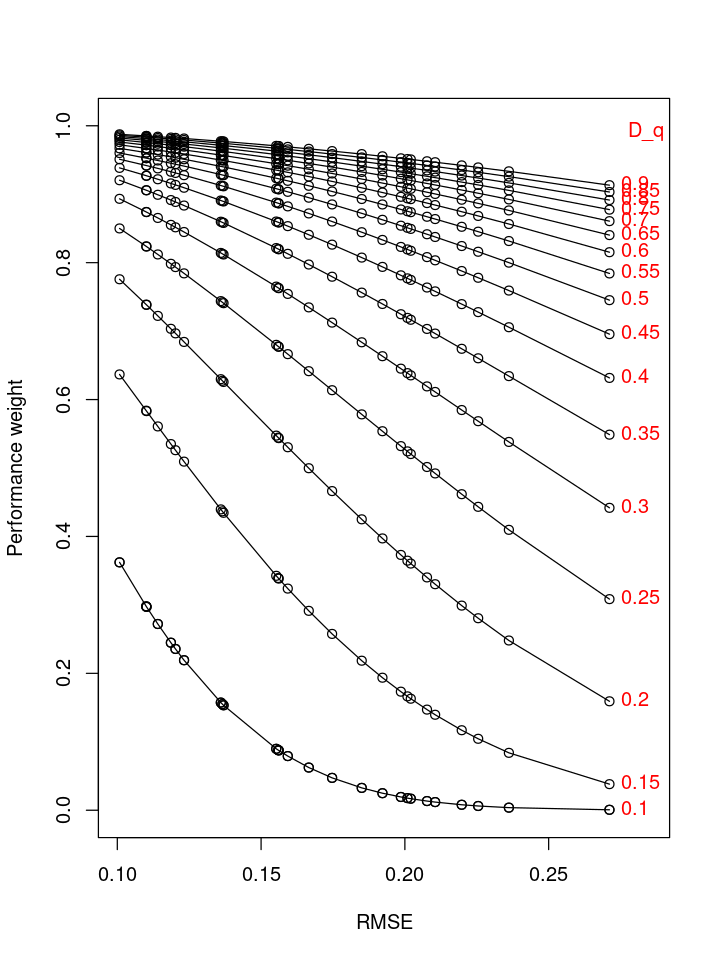

In [191]:
# -------------------------------------------------------------------
# Skill weighting function
# -------------------------------------------------------------------

get_w_q = function(rmse, D_q){ 
  out = exp(-(rmse/D_q)^2)
  out
}

D_q = 0.1 # guess for now

w_q = get_w_q(rmse = tas.rmse, D_q = D_q)

w_q

#dev.new(width = 5, height = 8)
options(repr.plot.width = 6, repr.plot.height = 8)
plot(tas.rmse, w_q, xlab = 'RMSE', ylab = 'Performance weight', pty = 'n',
     ylim = c(0,1),
     xlim = c(min(tas.rmse), (max(tas.rmse)*1.05))
     )

# A quick look at how D_q affects the skill weighting.
# A lower value (0.1 for example) brings the weighting of some models
# close to zero, and has a larger impact on the final weighting.
D_q.vec = seq(from = 0.1, to = 0.9, by = 0.05)

for(i in 1:length(D_q.vec)){

  w_q_i = get_w_q(rmse = tas.rmse, D_q = D_q.vec[i])
  tas.rmse.sort = sort(tas.rmse, index.return = TRUE)
  w_q_i.sort = w_q_i[tas.rmse.sort$ix]
  
  points(tas.rmse.sort$x, w_q_i.sort, type = 'o')

  text(
       tail(tas.rmse.sort$x,1),
       tail(w_q_i.sort,1),
       labels = D_q.vec[i],
       pos = 4,
       col = 'red'
       )
}
legend('topright', legend = 'D_q', text.col = 'red', bty = 'n')



[1] 0.3641921 0.5494102 0.2625684 0.4089090 0.4333951 0.3109261 0.2331294
 [8] 0.4044942 0.2453132 0.5274764 0.2787945 0.3282821 0.3169651 0.7280256
[15] 0.7490792 0.2200990 0.2582232 0.8479559 0.5441190 0.7421088 0.6121970
[22] 0.3128846 0.3268783 0.3254572 0.5627840 0.9889424 0.4854408

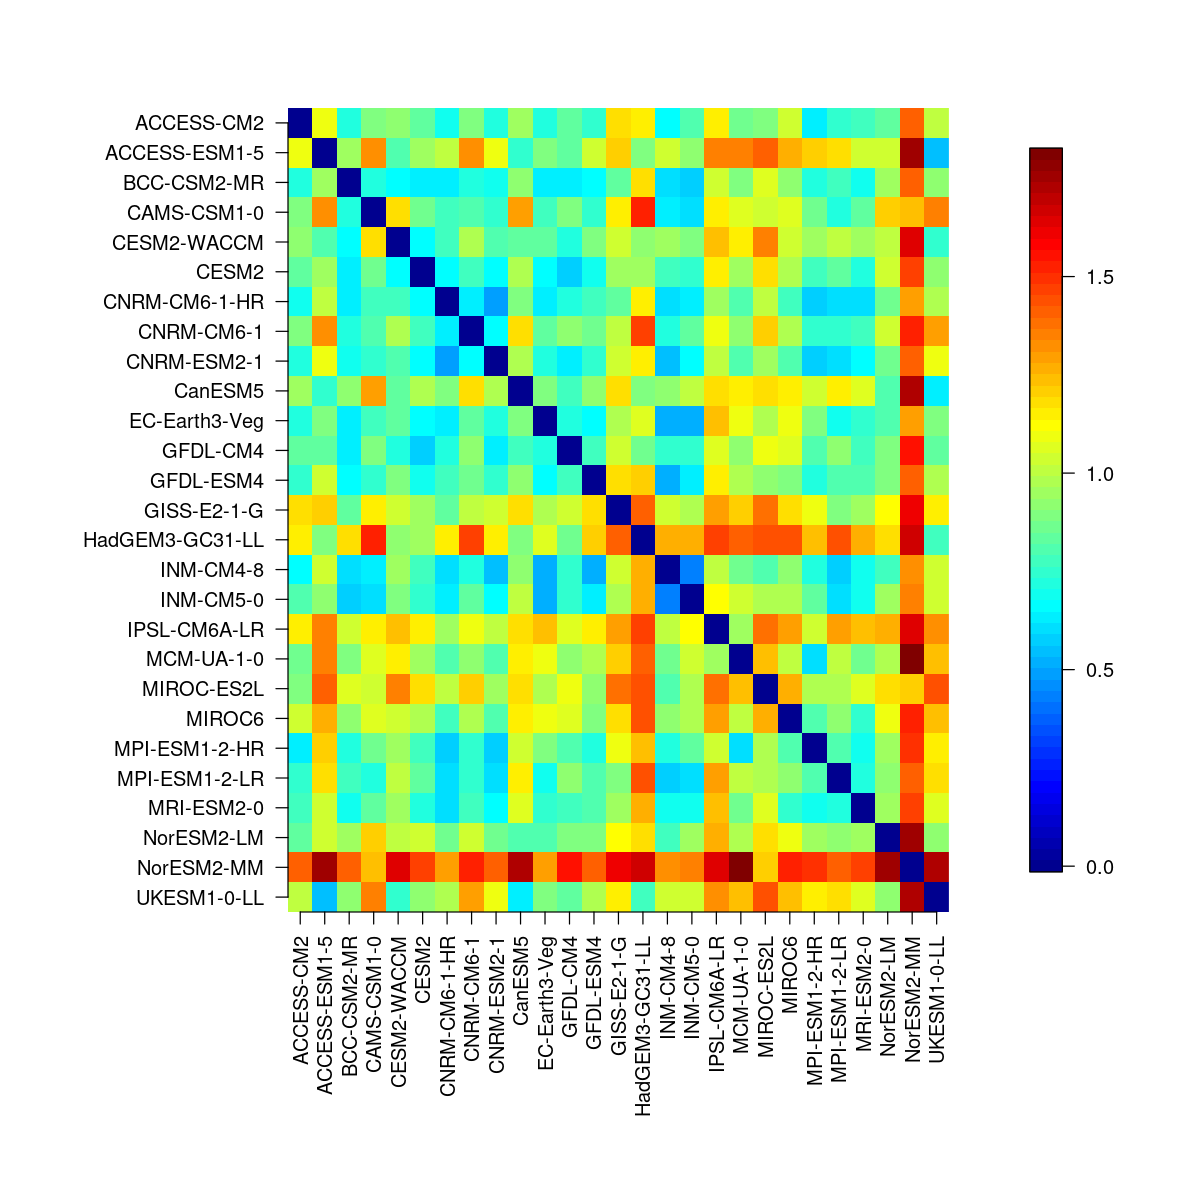

In [192]:
# -------------------------------------------------------------------
# Similarity weighting
# (Not including the observations at the moment)
# -------------------------------------------------------------------

# measure pairwise distance between models
d_ij = dist(varmat.anom, upper = TRUE, diag = TRUE)
d_ij.matrix = as.matrix(d_ij)

d_ij.formatted = apply(d_ij.matrix, 2, rev)

# I think this is the right way round.
#dev.new(width = 10, height = 10)
options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,8,3,3))
image.plot(1:nmods, 1:nmods,t(d_ij.formatted), axes = FALSE, xlab = '', ylab = '')
axis(2, at = nmods:1, labels = common.mods, las = 1)
axis(1, at = 1:nmods, labels = common.mods, las = 2)

# D_u is the radius of similarity
D_u = 0.5#* min.rmse

# S is a similarity score
S = exp( - (d_ij.matrix / D_u)^2)

# R_u is a model's repetition
R = rep(NA, nrow(S))

for(i in 1:nrow(S)){
  r = sum(S[i,][-i])
  R[i] = r
}

R_u = 1 + R

# w_u is the Similarity weighting
w_u = 1/R_u

w_u

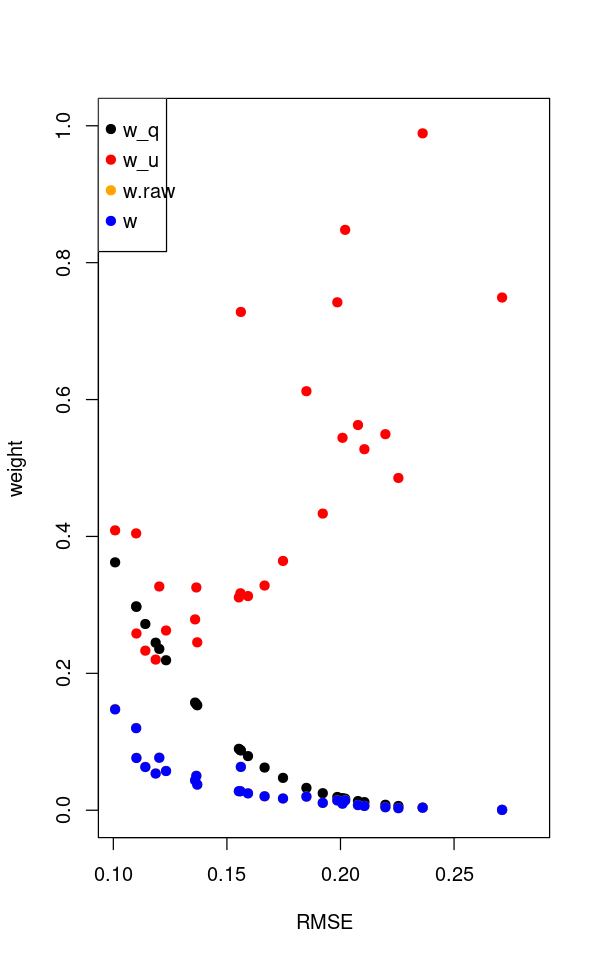

In [193]:
# -----------------------------------------------------------------------------------
# Final combination of the weights
# -----------------------------------------------------------------------------------

w.raw = w_q * w_u

# calculate A, a constant that ensures A sums to one
Ainv = sum(w.raw)
A = 1/Ainv

# final weights
w = w.raw*A

# I think that the independence weighting is dominating.
# Check how rmse and weighting interact

#dev.new(width = 5, height = 8)
options(repr.plot.width = 5, repr.plot.height = 8)
plot(tas.rmse, w_q, xlab = 'RMSE', ylab = 'weight', pty = 'n',
     ylim = c(0,1),
     xlim = c(min(tas.rmse), (max(tas.rmse)*1.05)),
     pch = 19
     )
points(tas.rmse, w_u, col = 'red', pch = 19)

points(tas.rmse, w.raw, col = 'orange', pch = 19)
points(tas.rmse, w, col = 'blue', pch = 19)
legend('topleft', pch = 19, legend = c('w_q','w_u','w.raw', 'w') , col = c('black', 'red','orange', 'blue'))



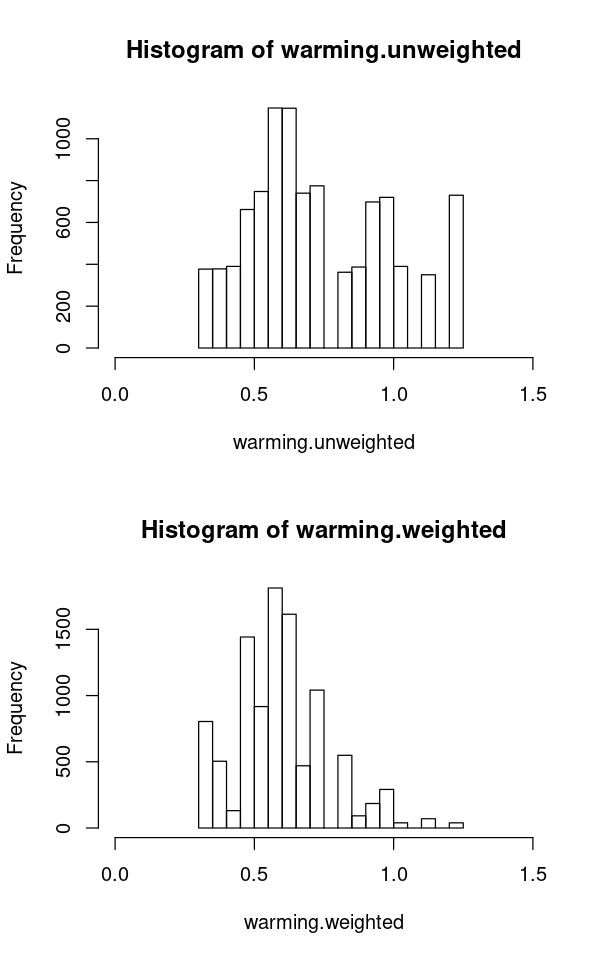

In [194]:
# Apply the weighting by sampling from the distribution of models, weighted
# according to w

# create index by which we sample the model matrix
n = 10000
ix.w = sample(1:nmods, n, replace = TRUE, prob = w) # weighted sample
ix = sample(1:nmods, n, replace = TRUE)             # unweighted sample

ts.sample.weighted = varmat.anom[ix.w, ]
ts.sample.unweighted = varmat.anom[ix, ]

mat.change = function(X){
  cols = ncol(X)
  out = X[, cols] - X[,1]
  out
}
warming.weighted = mat.change(ts.sample.weighted)
warming.unweighted = mat.change(ts.sample.unweighted)

#dev.new()
par(mfrow = c(2,1))
hist(warming.unweighted, xlim = c(0,1.5) )
hist(warming.weighted, xlim = c(0,1.5 ))


In [195]:
# So, what is the mean warming over the unweighted
# and weighted sample?

mean(warming.weighted)
mean(warming.unweighted)

[1] 0.5937022

[1] 0.7245121

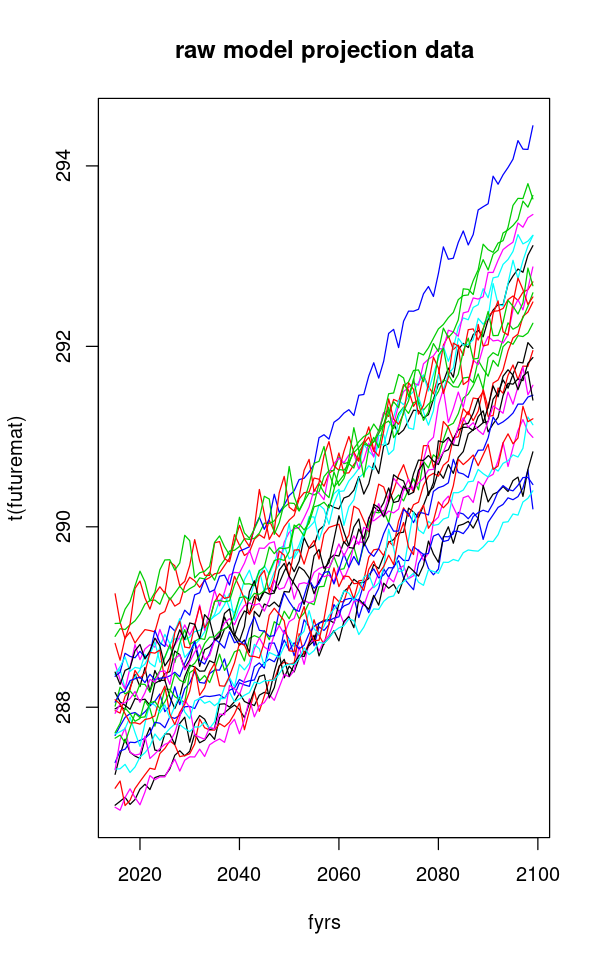

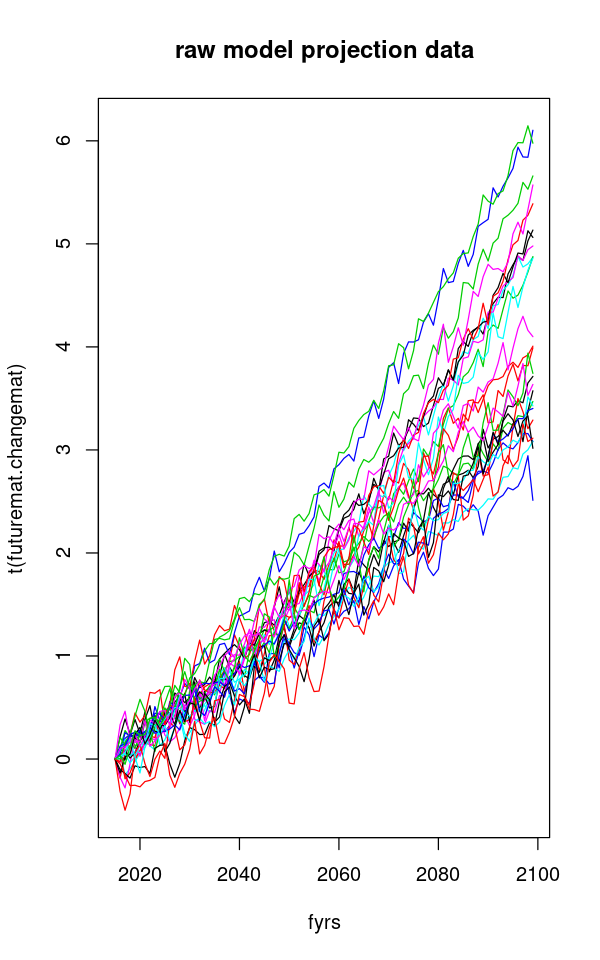

[1] 4.2006

[1] 3.910773

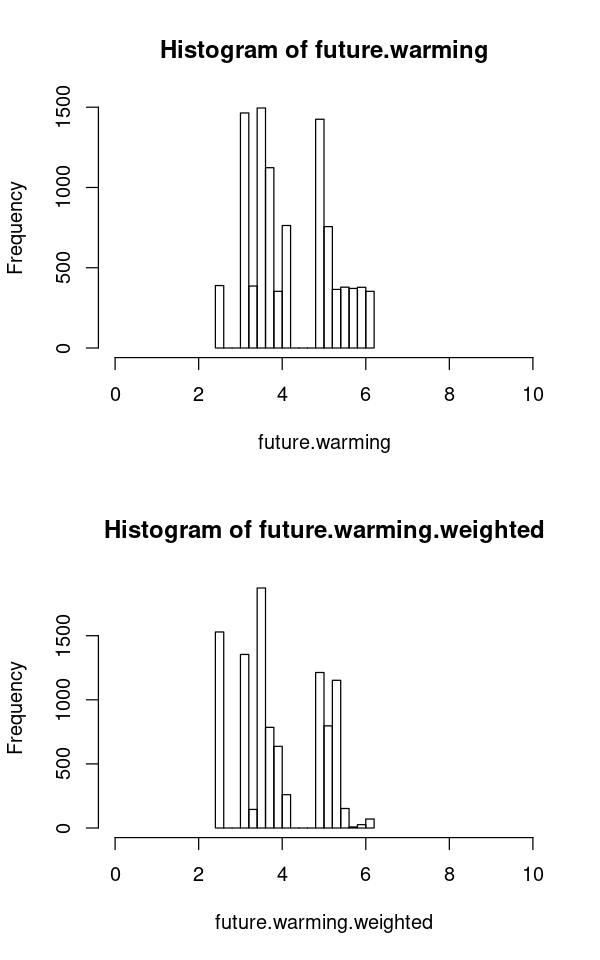

In [196]:
# --------------------------------------------------------------------------------------------
# Extract future projection data
#
#
# --------------------------------------------------------------------------------------------

# start with those models that are r1i1p1, to keep everything the same.
# Hadley models use f2 - they don't have f1

fyrs = 2015:2099
fnyr = length(fyrs)
futuremat = matrix(nrow = length(fn.ssp585.kept), ncol = fnyr)

for(i in 1:length(fn.ssp585.kept)){
# Open and extract data from the netcdf file
  fn = fn.ssp585.kept[i]
  fnpath = paste0("/data/users/hadaw/cmip6/areaavg/tas/", fn)

  nc = nc_open(fnpath)

  v = ncvar_get(nc, 'tas')
  #print(length(v))
  nc_close(nc)
  
  vhead = head(v, fnyr)
 
  futuremat[i, ] = vhead
}


matplot(fyrs,t(futuremat), type = 'l', lty = 'solid', main = 'raw model projection data')

# Amomalize to the mean
# varmat.anom is the variable timeseries matrix anomaly
futuremat.changemat = sweep(futuremat, 1, STATS = futuremat[,1])
future.diff = futuremat.changemat [,ncol(futuremat.changemat )]

matplot(fyrs, t(futuremat.changemat), type = 'l', lty = 'solid', main = 'raw model projection data')

future.warming = sample(future.diff , n, replace = TRUE)
future.warming.weighted = sample(future.diff, n, replace = TRUE, prob = w)


#dev.new()
par(mfrow = c(2,1))
hist(future.warming, xlim = c(0,10))
hist(future.warming.weighted, xlim  = c(0,10))


mean(future.warming)
mean(future.warming.weighted)


In [197]:
# I don't think my resampling technique works.

# try a very large number of samples for the mean 

mfu  = rep(NA,n)
mfw =  rep(NA,n)

sdfu  = rep(NA,n)
sdfw =  rep(NA,n)

for(i in 1:n){

    sample.future.unweighted = sample(future.diff, nmods, replace = TRUE)
    sample.future.weighted = sample(future.diff, nmods, replace = TRUE, prob = w)
    
    mfu[i] = mean(sample.future.unweighted )
    mfw[i] = mean(sample.future.weighted)
    
    sdfu[i] = sd(sample.future.unweighted )
    sdfw[i] = sd(sample.future.weighted) 
}

# mean of all the means of the bootstap sample
mean(mfu)
mean(mfw)

# mean of all the standard deviations of the bootstrap samples
mean(sdfu)
mean(sdfw)



[1] 4.208082

[1] 3.915882

[1] 1.005463

[1] 0.9978105